# Regresión Poisson

Juan Sosa PhD

Email jcsosam@unal.edu.co

GitHub https://github.com/jstats1702

Samuel Sánchez (Python y revisión R)

Email ssanchezgu@unal.edu.co

GitHub https://github.com/Samuel-col

In [1]:
# Librerías base
import numpy as np
import pandas as pd
# Funciones de densidad y muestrear de ellas
import scipy.stats as st
import scipy.special as fun
# Función de autocorrelación
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# Modelos lineales generalizados frecuentistas
import statsmodels.api as sm
# MCMC
import pyjags as pj
import arviz as av
# Gráficos
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Modelo

A continuación se presenta la formulación básica de un modelo de Regresión Poisson como un **modelo lineal generalizado** (GLM, *generalized linear model*):

**Distribución muestral**:
$$
y_i\mid\theta_i\stackrel{\text {iid}}{\sim}\textsf{Poisson}(\theta_i)\,,\qquad i = 1,\ldots,n
$$
donde
$$
\log(\theta_i) = \boldsymbol{\beta}^{\textsf{T}}\boldsymbol{x}_i = \sum_{j=1}^k\beta_j\, x_{i,j}
$$
con $\boldsymbol{\beta}=(\beta_1,\ldots,\beta_k)$ y $\boldsymbol{x} = (x_{i,1},\ldots,x_{i,k})$. 

Observe que la **función de enlace** (*link function*) en este modelo lineal generalizado es la función $\log$.

**Distribuciones previas conjugadas** para modelos lineales generalizados **no existen** (a excepción del modelo de regresión Normal).

**Distribución previa**:
$$
\boldsymbol{\beta}\sim\textsf{N}(\boldsymbol{\beta}_0,\Sigma_0)
$$

Los **parámetros** del modelo son $(\beta_1,\ldots,\beta_k)$.

Los **hiperparámetros** del modelo son $(\boldsymbol{\beta}_0,\Sigma_0)$.


## 2 Distibución conjunta posterior

$$
\begin{align*}
p(\boldsymbol{\beta}\mid\boldsymbol{y}) &\propto p(\boldsymbol{y}\mid\boldsymbol{\beta})\,p(\boldsymbol{\beta}) \\
&= \prod_{i=1}^n \textsf{Poisson}(y_i\mid\theta_i) \times\textsf{N}(\boldsymbol{\beta}_0,\Sigma_0) \\
&= \prod_{i=1}^n \frac{e^{-\theta_i}\,\theta_i^{y_i}}{y_i!} \times \exp\left\{ -\tfrac{1}{2}(\boldsymbol{\beta}-\boldsymbol{\beta}_0)^{\textsf{T}}\Sigma_0^{-1}(\boldsymbol{\beta}-\boldsymbol{\beta}_0) \right\} \\
&\propto \prod_{i=1}^n e^{-\theta_i}\,\theta_i^{y_i} \times \exp\left\{ -\tfrac{1}{2} \left[ \boldsymbol{\beta}^{\textsf{T}}\Sigma_0^{-1}\boldsymbol{\beta} - 2\boldsymbol{\beta}^{\textsf{T}}\Sigma_0^{-1}\boldsymbol{\beta}_0 \right]   \right\}
\end{align*}
$$
con $\log(\theta_i) = \boldsymbol{\beta}^{\textsf{T}}\boldsymbol{x}_i$. 

Por lo tanto, en **escala logaritmica**, se tiene que
$$
\log p(\boldsymbol{\beta}\mid\boldsymbol{y}) \propto \sum_{i=1}^n(y_i\log(\theta_i) - \theta_i) -\tfrac{1}{2} \left[ \boldsymbol{\beta}^{\textsf{T}}\Sigma_0^{-1}\boldsymbol{\beta} - 2\boldsymbol{\beta}^{\textsf{T}}\Sigma_0^{-1}\boldsymbol{\beta}_0 \right] 
$$

Observe que $p(\boldsymbol{\beta}\mid\boldsymbol{y})$ no corresponde a ninguna familia paramétrica de distribuciones conocida.


## 3 Algorithmo de Metropolis-Hastings

El algoritmo Metropolis-Hastings es un método genérico de aproximación de **cualquier distribución posterior**.

El problema radica cuando $p(\boldsymbol{\theta}\mid \boldsymbol{y})$ no tiene una distribución estándar conocida de la cual sea posible simular fácilmente.


### 3.1 Metropolis

**Algoritmo:**

Dado un estado actual $\theta^{(b)}$ del parámetro $\theta$, se genera el siguiente estado $\theta^{(b+1)}$ como sigue: 

1. Simular $\theta^*\sim J(\theta\mid\theta^{(b)})$ donde $J$ es una distribución **simétrica**: $J(\theta_1\mid\theta_2) = J(\theta_2\mid\theta_1)$.
Esta distribución se denomina **distribución de propuestas** (*proposal distribution*). Típicamente,
$$
J(\theta\mid\theta^{(b)}) = \textsf{N}(\theta\mid\theta^{(b)},\delta^2)\qquad\text{o}\qquad J(\theta\mid\theta^{(b)}) = \textsf{U}(\theta\mid\theta^{(b)} - \delta, \theta^{(b)} + \delta)
$$
donde $\delta$, conocido como **parámetro de ajuste**, se escoge de forma que el algoritmo funcione eficientemente.
2. Calcular la tasa de aceptación:
$$
r = \frac{p(\theta^*\mid y)}{p(\theta^{(b)}\mid y)}\,.
$$
Para brindar estabilidad numérica en el procesamiento, esta tasa usualmente se calcula primero en escala logarítmica:
$$
r = \exp\left( \log p(\theta^*\mid y) - \log p(\theta^{(b)}\mid y) \right)\,.
$$
3. Establecer:
$$
\theta^{(b+1)} =
\left\{
  \begin{array}{ll}
    \theta^*\,     , & \hbox{con probabilidad $\min(1,r)$;} \\
    \theta^{(b)}\, , & \hbox{con probabilidad $1-\min(1,r)$.}
  \end{array}
\right.
$$


### 3.2 Observaciones

- Este algoritmo produce una secuencia de valores $\theta^{(1)},\ldots,\theta^{(B)}$, donde $\theta^{(b+1)}$ depende de los valores previos únicamente a través de $\theta^{(b)}$, y por lo tanto la secuencia es una **Cadena de Markov**.
- La **correlación de la cadena** depende del valor de $\delta$ en la distribución de propuestas. 
- Es una práctica común **elegir un valor** de $\delta$ tal que la **tasa de aceptación** esté entre 30\% y 50\%. Existen **algoritmos adaptativos** para elegir automáticamente el valor de $\delta$.


### 3.3 Metropolis-Hastings

El algoritmo Metrópolis-Hastings **generaliza los algoritmos de Gibbs** y **Metropolis** al permitir una distribución de propuesta arbitraria:

**Algoritmo:**

Dado un estado actual $\theta^{(b)}$ del parámetro $\theta$, se genera el siguiente estado $\theta^{(b+1)}$ como sigue: 

1. Simular $\theta^*\sim J(\theta\mid\theta^{(b)})$ donde $J$ es una **distribución de propuestas arbitraria**.

2. Calcular la tasa de aceptación:
$$
r = \frac{p(\theta^*\mid y)}{p(\theta^{(b)}\mid y)}\,\frac{J(\theta^{(b)}\mid\theta^*)}{J(\theta^*\mid \theta^{(b)})}\,.
$$
3. Establecer:
$$
\theta^{(b+1)} =
\left\{
  \begin{array}{ll}
    \theta^*\,     , & \hbox{con probabilidad $\min(1,r)$;} \\
    \theta^{(b)}\, , & \hbox{con probabilidad $1-\min(1,r)$.}
  \end{array}
\right.
$$


### 3.4 Observaciones

- Cada paso del **algoritmo de Gibbs** se puede ver como la generación de una propuesta de una distribución condicional completa y luego aceptarla con probabilidad 1.
- El algoritmo de Gibbs y el algoritmo de Metropolis son **casos particulares** del algoritmo de Metropolis-Hastings.


## 4 Ejemplo: Modelo Normal

Algoritmo de Metropolis en un modelo Normal con varianza conocida.

**Distribución muestral:**
$$
y_i\mid\theta \stackrel{\text {iid}}{\sim}\textsf{Normal}(\theta, 1)\,,\qquad i = 1,\ldots,n
$$

**Distribución previa:**
$$
\theta \sim \textsf{Normal}(\mu, \tau^2)
$$


In [2]:
# simular datos
n  = 5
s2 = 1
np.random.seed(1)
y  = np.round(st.norm.rvs(loc = 10,scale = 1, size = n),2)
# previa
t2 = 10
mu = 5
# Metropolis
theta = 0     # valor inicial
delta = 0.75  # parámetro de ajuste
S     = 10000 # número de muestras
THETA = []    # almacenamiento
# cadena
np.random.seed(1)
for s in range(S):
    # 1. propuesta
    theta_star = st.norm.rvs(theta, scale = np.sqrt(delta))
    # 2. tasa de aceptación
    log_r      = (
            np.sum(st.norm.logpdf(y, loc = theta_star, scale = np.sqrt(s2))) +  # log(p(y | theta*))  | El producto de estas densidades (sin log)
                st.norm.logpdf(theta_star, loc = mu, scale = np.sqrt(t2))       # log(p(theta* | mu)) | es proporcional a p(theta* | y)
    ) - (
            np.sum(st.norm.logpdf(y, loc = theta, scale = np.sqrt(s2))) +       # log(p(y | theta))   | El producto de estas densidades (sin log)
                st.norm.logpdf(theta, loc = mu, scale = np.sqrt(t2))            # log(p(theta | mu))  | es proporcional a p(theta | y)
    )
    # 3. actualizar
    if st.uniform.rvs() < np.exp(log_r):
        theta = theta_star
    # 4. almacenar
    THETA.append(theta)

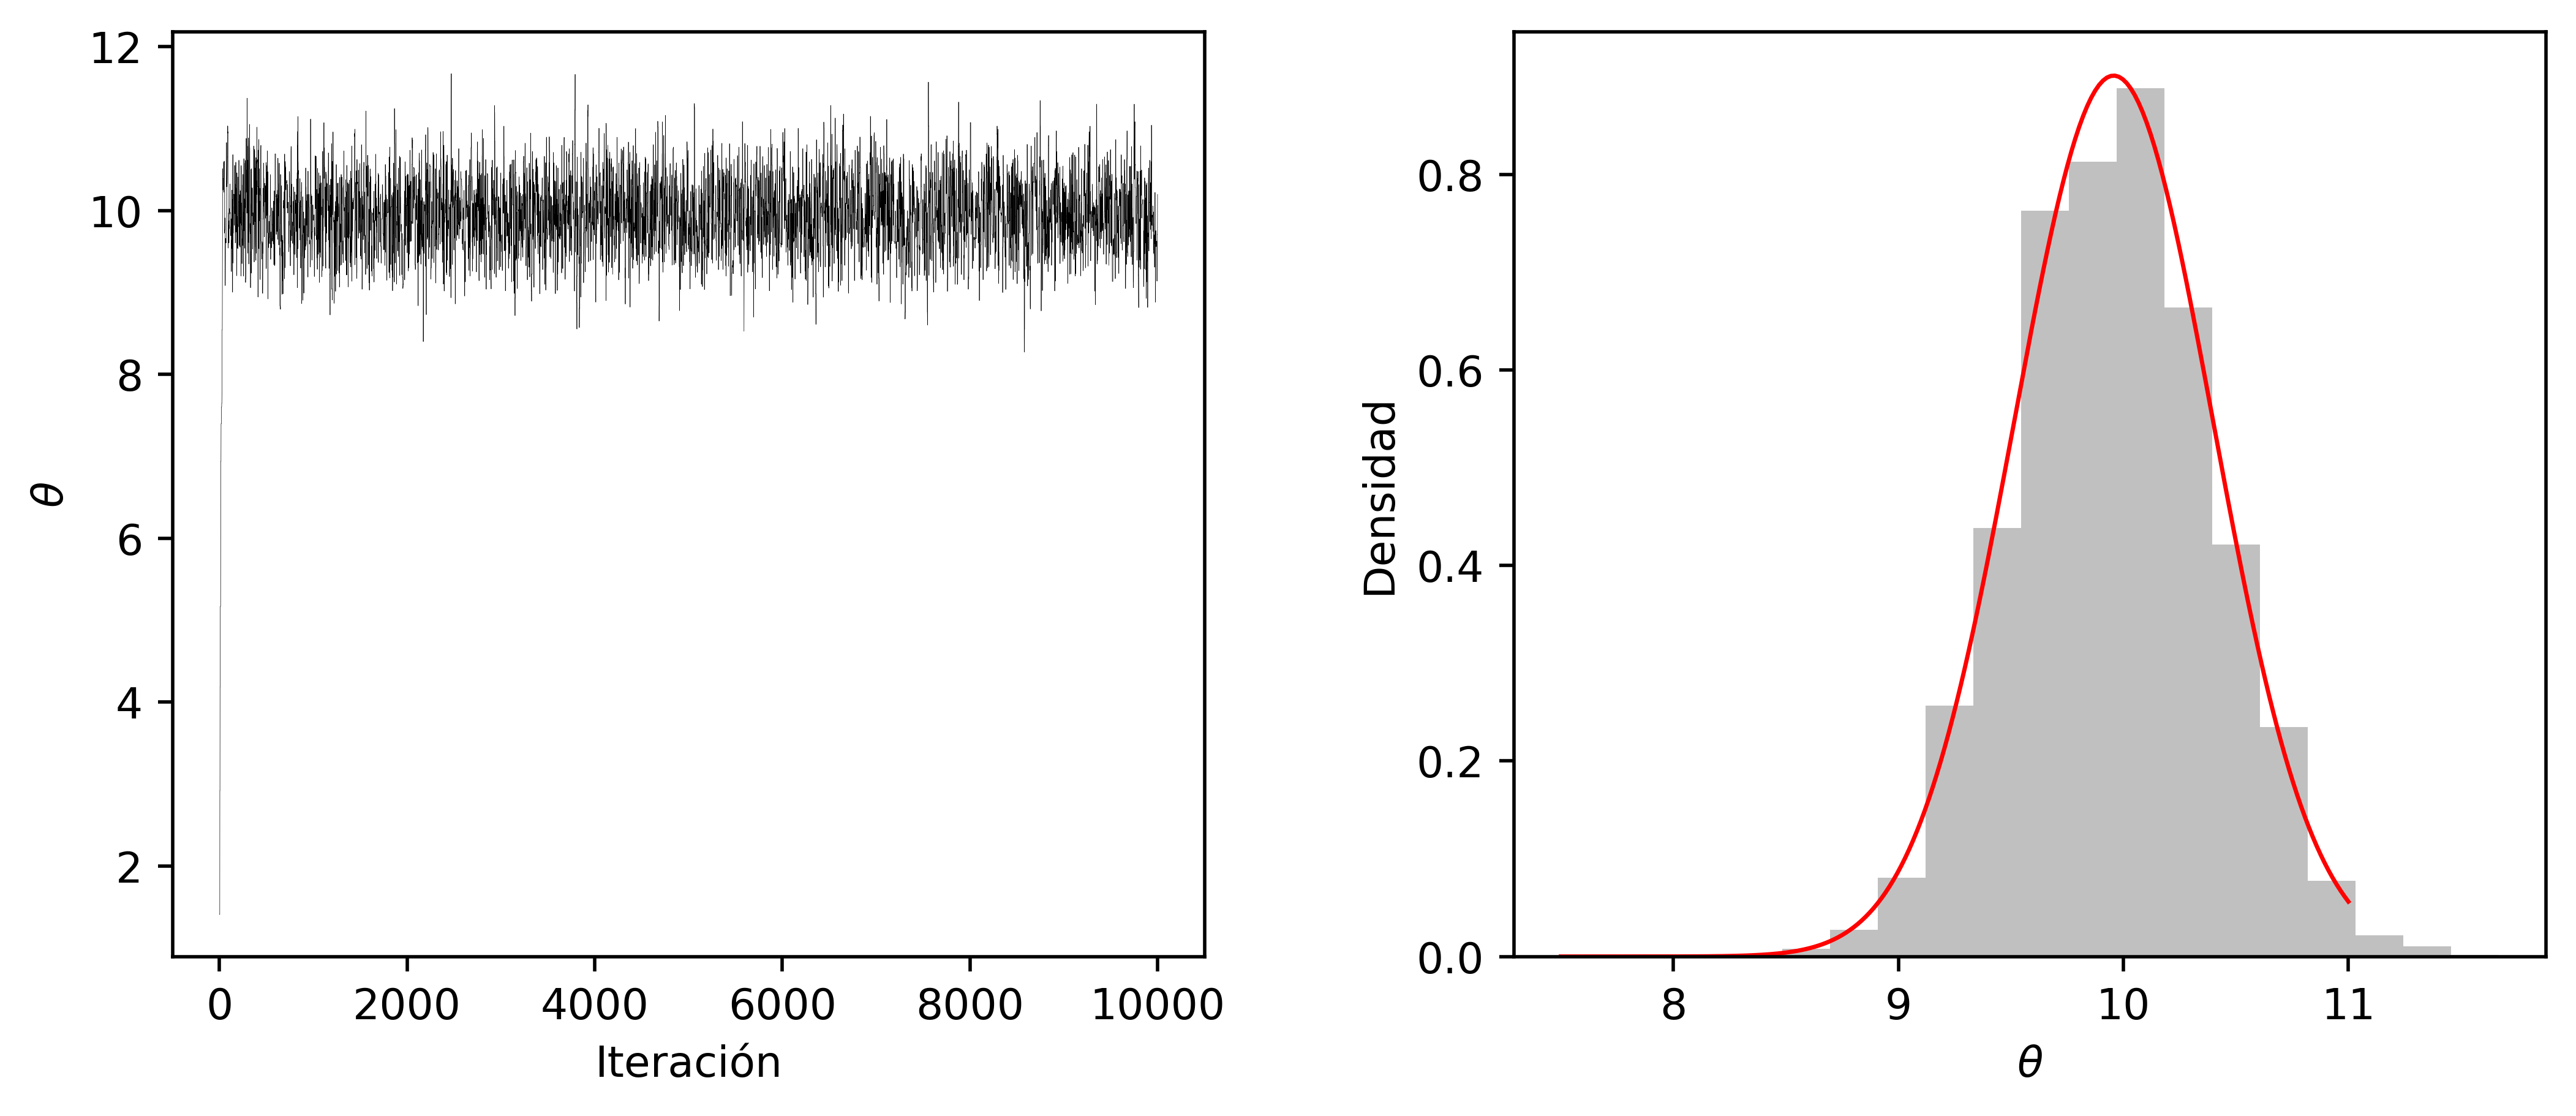

In [3]:
f, ax = plt.subplots(1, 2, figsize = (10,4),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

ax[0].plot(THETA,color = 'black',linewidth = 0.1)
ax[0].set_xlabel('Iteración')
ax[0].set_ylabel(r'$\theta$')

th = np.linspace(7.5,11,num = 200)
mu_n = (mu/t2 + np.mean(y)*n/s2)/(1/t2 + n/s2) 
t2_n = 1/(1/t2 + n/s2)
ax[1].hist(THETA[100:],color = '#c0c0c0',bins = 16,density = True)
ax[1].plot(th,st.norm.pdf(th,loc = mu_n,scale = np.sqrt(t2_n)),color = 'red',linewidth = 1)
ax[1].set_xlabel(r'$\theta$')
ax[1].set_ylabel('Densidad')

plt.show()

In [4]:
ACR    = [] # tasa de aceptaciones
ACF    = [] # autocorrelaciones
THETAA = [] # muestras
for delta2 in 2.0**np.array([-5,-1,1,5,7]):
    # parametros iniciales
    THETA = []
    s     = 10000
    theta = 0
    acs   = 0 # tasa de aceptación
    # cadena
    np.random.seed(1)
    for s in range(S):
        # 1. propuesta
        theta_star = st.norm.rvs(theta, scale = np.sqrt(delta2))
        # 2. tasa de aceptación
        log_r      = (
                np.sum(st.norm.logpdf(y, loc = theta_star, scale = np.sqrt(s2))) +  # log(p(y | theta*))  | El producto de estas densidades (sin log)
                    st.norm.logpdf(theta_star, loc = mu, scale = np.sqrt(t2))       # log(p(theta* | mu)) | es proporcional a p(theta* | y)
        ) - (
                np.sum(st.norm.logpdf(y, loc = theta, scale = np.sqrt(s2))) +       # log(p(y | theta))   | El producto de estas densidades (sin log)
                    st.norm.logpdf(theta, loc = mu, scale = np.sqrt(t2))            # log(p(theta | mu))  | es proporcional a p(theta | y)
        )
        # 3. actualizar
        if st.uniform.rvs() < np.exp(log_r):
            theta = theta_star
            acs += 1
        # 4. almacenar
        THETA.append(theta)
    # fin MCMC
    # almacenar valores de todos los casos (delta2)
    ACR.append(acs/s)
    ACF.append(acf(THETA)[1])
    THETAA.append(THETA)
THETAA = np.array(THETAA).T

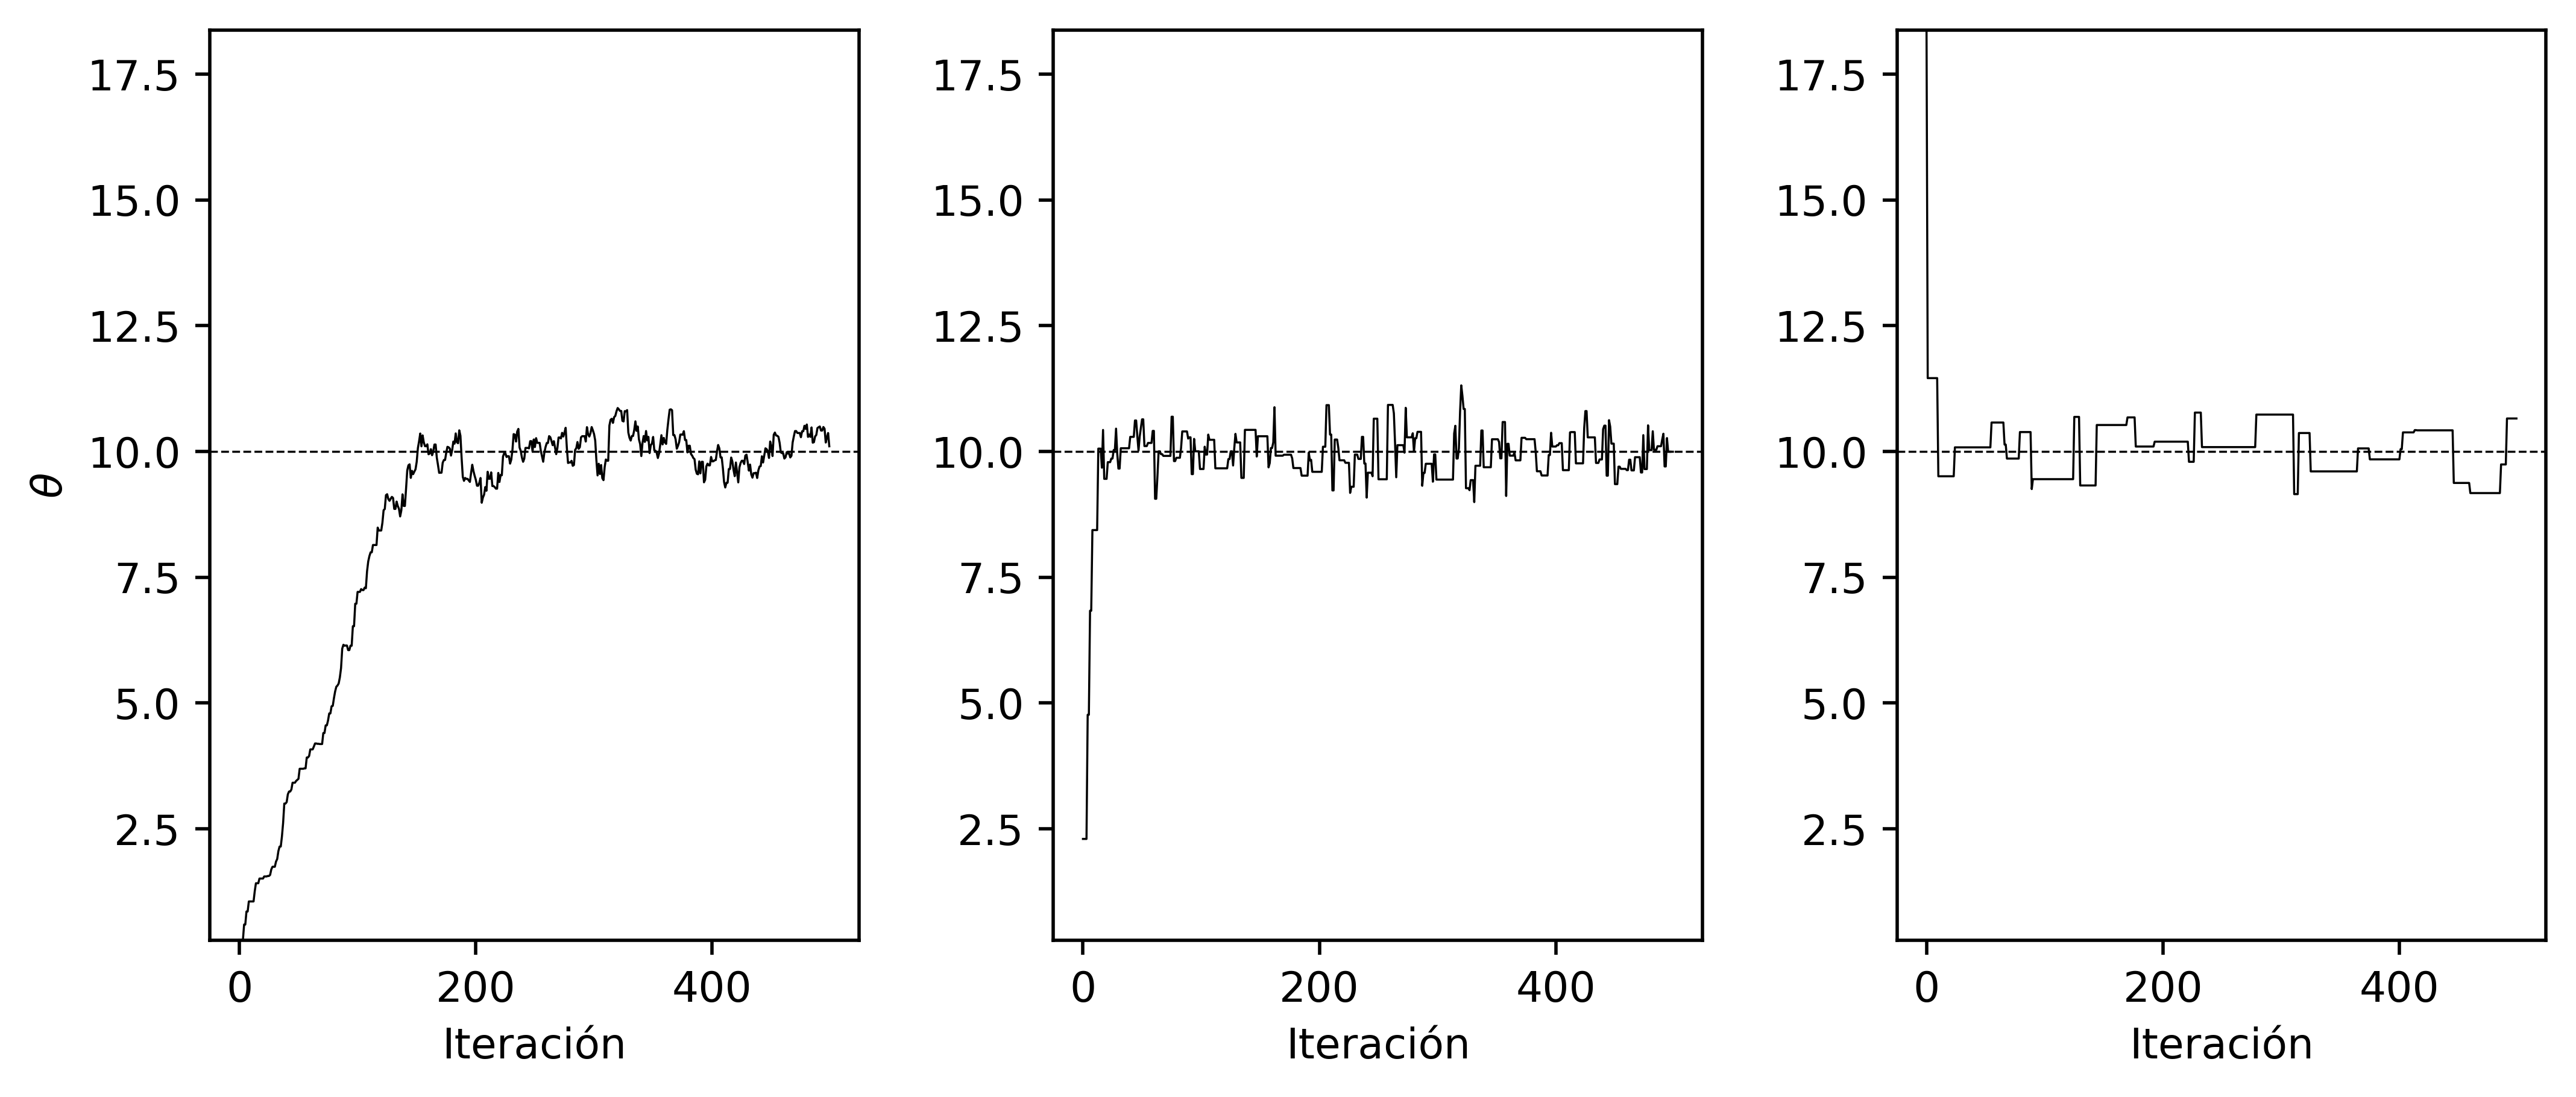

In [5]:
laby = [r'$\theta$','','']

f, ax = plt.subplots(1, 3, figsize = (10,4),dpi = 500)
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for k in [0,2,4]:
    ax[int(k/2)].plot(THETAA[:500,k],color = 'black',linewidth = 0.5)
    ax[int(k/2)].set_ylim((np.min(THETAA),np.max(THETAA)))
    ax[int(k/2)].set_xlabel('Iteración')
    ax[int(k/2)].set_ylabel(laby[int(k/2)])
    ax[int(k/2)].axhline(10,ls = '--', color = 'black', linewidth = 0.5)

In [6]:
# tasas de aceptación
np.round(ACR,3)

array([0.865, 0.572, 0.353, 0.103, 0.053])

In [7]:
# autocorrelaciones
np.round(ACF,3)

array([0.975, 0.763, 0.688, 0.876, 0.912])

In [8]:
# tamaños efectivos de muestra
np.round([av.ess(THETAA[:,k],method = 'mean') for k in range(5)],3)

array([ 103.762,  735.986, 1888.294,  559.121,  348.375])

## 5 Ejemplo: Regresión Poisson

Actividades de reproducción de gorriones en función de la edad.

Caracterizar el número de crías en función de la edad.

***Arcese, P., Smith, J. N., Hochachka, W. M., Rogers, C. M., & Ludwig, D. (1992). Stability, regulation, and the determination of abundance in an insular song sparrow population. Ecology, 73(3), 805-822.***

![](sparrow.jpeg)

- $y_i\,\,\,\,$: número de crías, para $i=1,\ldots,n$.
- $x_{i,j}\,$: predictor $j$ observado en el individuo $i$, para $i=1,\ldots,n$ y $j=1,\ldots,k$.


In [9]:
#-------------------------------------------------------------------------------
# Descripcion: 
# Actividades de reproduccion de gorriones en funcion de la edad (Arcese et al, 1992).
# n = 52 gorriones hembras.
# "age"     : edad.
# "fledged" : numero de crias.
#-------------------------------------------------------------------------------

############
### data ###
############
spfage = pd.DataFrame(
    np.array([3, 1, 1, 2, 0, 0, 6, 3, 4, 2, 1, 6, 2, 3, 3, 4, 7, 2, 2, 1, 
              1, 3, 5, 5, 0, 2, 1, 2, 6, 6, 2, 2, 0, 2, 4, 1, 2, 5, 1, 2, 
              1, 0, 0, 2, 4, 2, 2, 2, 2, 0, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
              1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
              1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 
              2, 2, 2, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 
              4, 4, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 6, 1, 1, 9, 9, 1, 1, 
              1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 25, 25, 16, 16, 
              16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 25, 16, 16, 16, 16, 
              25, 25, 25, 25, 9, 9, 9, 9, 9, 9, 9, 36, 1, 1]).reshape((4,52)).T,
    columns = ['fledged','intercept','age','age2'])
# diseño
spf  = spfage.fledged # y = variable dependiente (respuesta)
age  = spfage.age     # x1 = variable independiente 1
age2 = age**2         # x2 = variable independiente 2

Text(0.5, 0, 'Edad (años)')

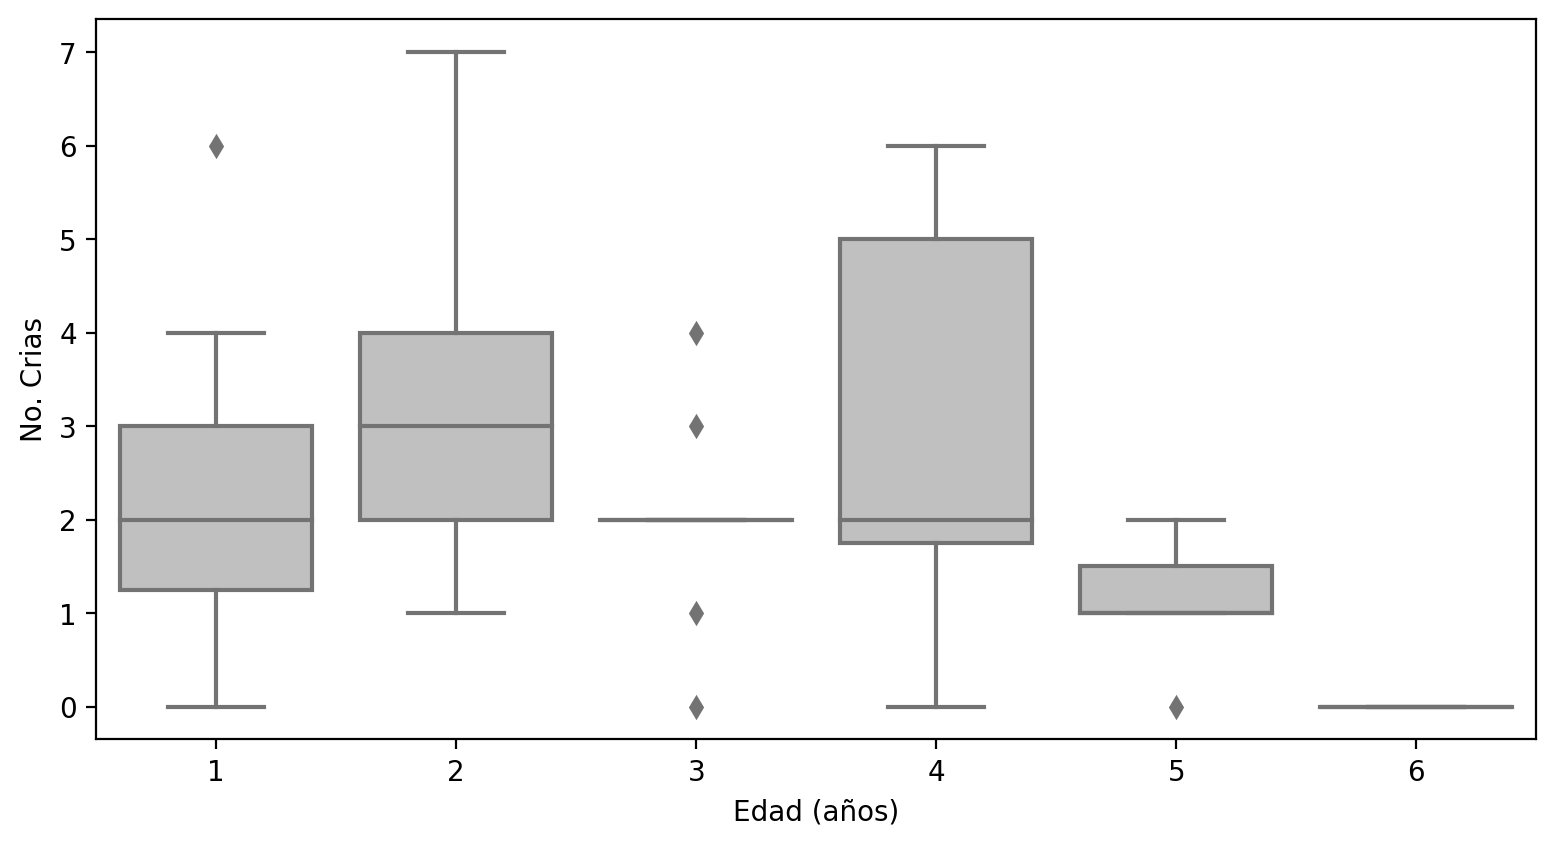

In [10]:
############################
### analisis descriptivo ###
############################
f = plt.figure(figsize = (8,4), dpi = 200)
ax = f.add_axes([0.1,0.1,0.9,0.9])

sns.boxplot(x = 'age',y = 'fledged',data = spfage, ax = ax,
           color = '#c0c0c0')
ax.set_ylabel('No. Crias')
ax.set_xlabel('Edad (años)')

In [11]:
# GLM (frecuentista)
design_mat = np.vstack([np.ones(len(spf)),age,age2]).T
sm.GLM(spf,design_mat,family = sm.families.Poisson()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                fledged   No. Observations:                   52
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96.388
Date:                Sun, 20 Nov 2022   Deviance:                       67.837
Time:                        16:17:07   Pearson chi2:                     61.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1466
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2766      0.442      0.626      0.532      -0.590       1.143
x1             0.6817      0.338      2.014      0.044       0.018       1.345
x2            -0.1345      0.058     -2.325      0.020      -0.248      -0.021
==============================================================================
"""


En muchos problemas, la varianza posterior es una elección eficiente para la 
distribución de propuestas. Aunque no se conoce la varianza posterior antes de 
ejecutar el algoritmo de Metrópolis, basta con utilizar una aproximación.
Si esto da como resultado una tasa de aceptación demasiado alta o demasiado baja, 
siempre es posible ajustar la variabilidad de la propuesta en consecuencia.


In [12]:
# datos
y = spf        # variable respuesta
X = design_mat # matriz de diseño
n = len(y)     # tamaño de la muestra
p = X.shape[1] # número de predictores
# previa
pmn_beta = np.zeros(p) # beta0 = 0
psd_beta = 10*np.ones(p) # Sigma0 = 10*I
# log: función de enlace
# y + 1/2 evitar los problemas en la forntera con 0
var_prop = np.var(np.log(y + 1),ddof = 1) * np.linalg.inv(np.dot(X.T,X)) # matriz de varianza propuesta
beta = np.zeros(p) # valor inivial beta
####### algoritmo de metropolis
S    = 50000
BETA = np.empty((S,p))
ac   = 0
ncat = np.floor(S/10)
####### cadena
np.random.seed(1)
for s in range(S):
    # 1. propuesta
    beta_p = st.multivariate_normal.rvs(mean = beta,cov = var_prop)
    # 2. tasa de aceptación
    lhr = (
        np.sum(st.poisson.logpmf(y,mu = np.exp(np.dot(X,beta_p)))) +              # log(p(y|beta*))       | El producto de estas densidades (sin log)
        np.sum(st.norm.logpdf(beta_p, loc = pmn_beta, scale = np.sqrt(psd_beta))) # log(p(beta*| previa)) | es proporcional a p(beta*|y)
    ) - (
        np.sum(st.poisson.logpmf(y,mu = np.exp(np.dot(X,beta)))) +                # log(p(y|beta))        | El producto de estas densidades (sin log)
        np.sum(st.norm.logpdf(beta, loc = pmn_beta, scale = np.sqrt(psd_beta)))   # log(p(beta|previa))   | es proporcional a p(beta|y)
    )
    # 3. actualizar
    if st.uniform.rvs() < np.exp(lhr):
        beta = beta_p
        ac  += 1
    # 4. almacenar
    BETA[s,:] = beta
    # 5. progreso
    if (s+1)%ncat == 0:
        print(100*np.round(s/S,1),'% completed ...', sep = '')

10.0% completed ...
20.0% completed ...
30.0% completed ...
40.0% completed ...
50.0% completed ...
60.0% completed ...
70.0% completed ...
80.0% completed ...
90.0% completed ...
100.0% completed ...


In [13]:
####### fit mcmc

In [14]:
# tasa de aceptación
np.round(100*ac/S,1)

52.6

In [15]:
# diagnosticos
np.round([av.ess(BETA[:,k],method = 'mean') for k in range(p)],1)

array([3176.9, 2987.9, 2599. ])

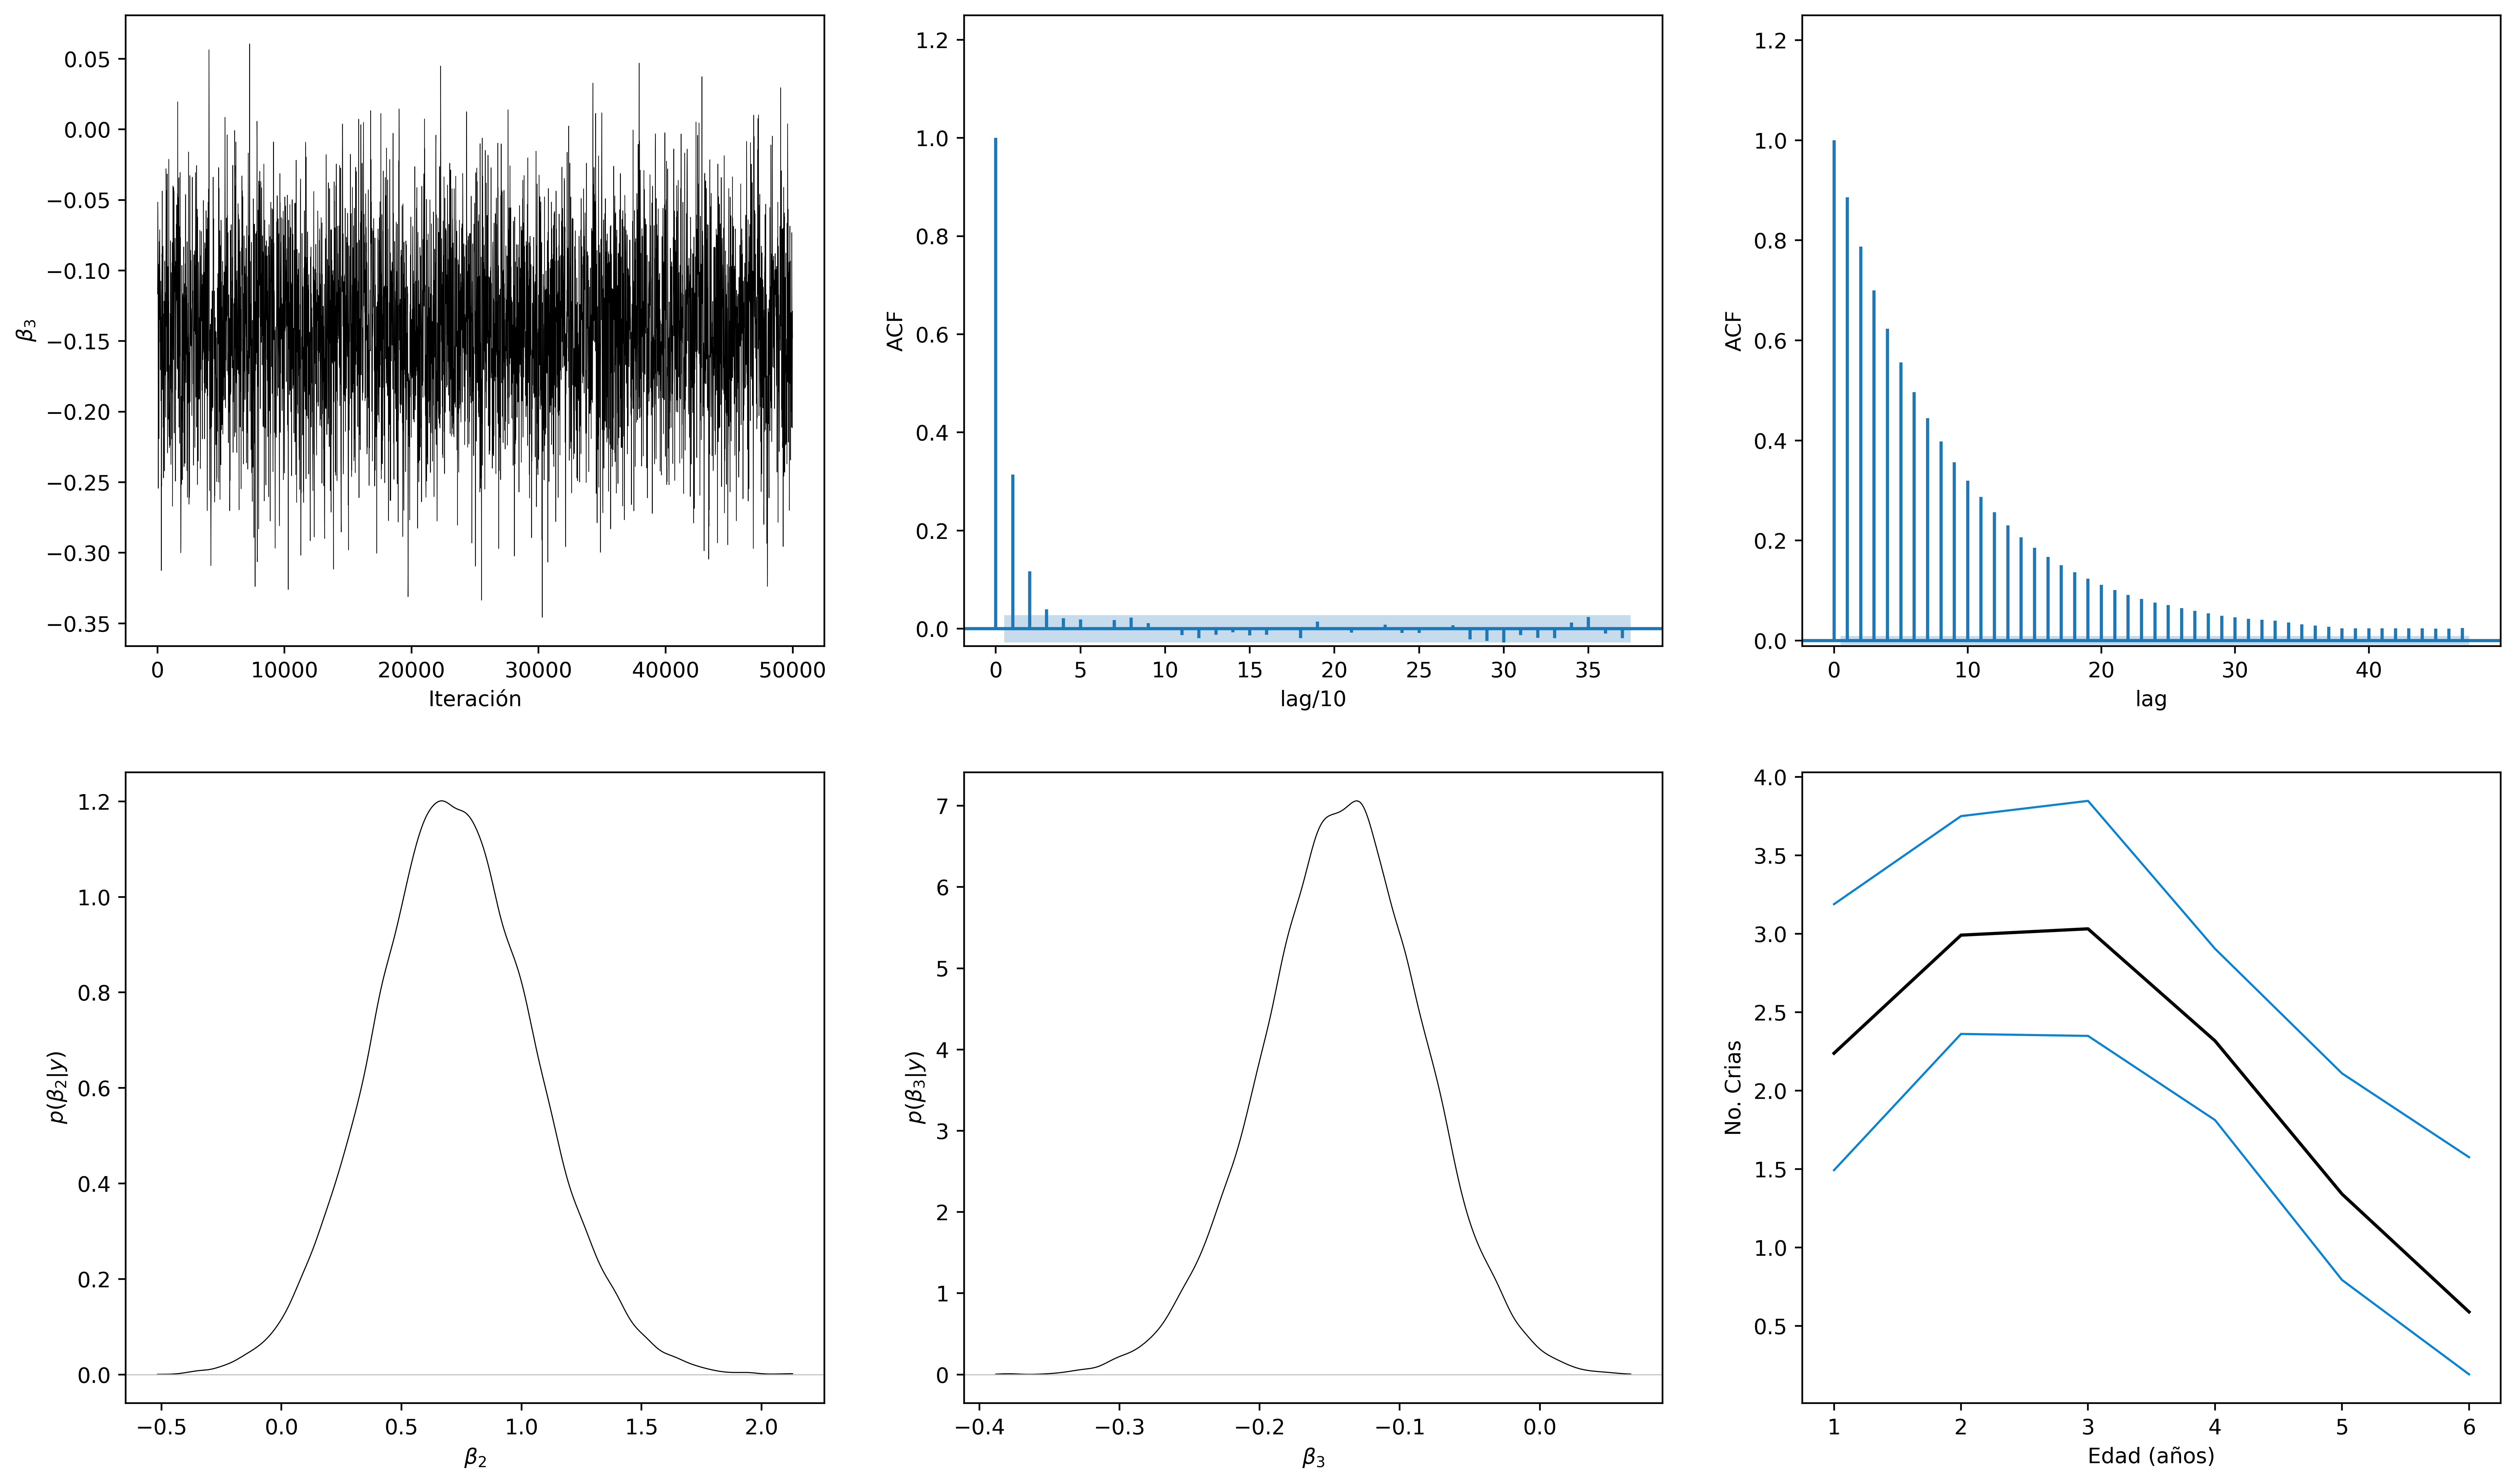

In [16]:
f, ax = plt.subplots(2, 3, figsize = (20,12),dpi = 500)
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

# Cadena de beta_j
thin = np.arange(start = 10,stop = S, step = 10) # muestreo sistemático
j = 2
ax[0,0].plot(thin,BETA[thin,j],
             linewidth = 0.3,
             color = 'black')
ax[0,0].set_xlabel('Iteración')
ax[0,0].set_ylabel(r'$\beta_3$')

# ACF de la cadena adelgazada
plot_acf(BETA[thin,j],ax = ax[0,1],
         adjusted = True,
         bartlett_confint=False,
         marker = '',
         auto_ylims=True,
         title = '')
ax[0,1].set_xlabel('lag/10')
ax[0,1].set_ylabel('ACF')

# ACF de la cadena original
plot_acf(BETA[:,j],ax = ax[0,2],
         adjusted = True,
         bartlett_confint=False,
         marker = '',
         auto_ylims=True,
         title = '')
ax[0,2].set_xlabel('lag')
ax[0,2].set_ylabel('ACF')

# Densidad de beta_2
beta2_grid = np.linspace(np.min(BETA[:,1]),
                         np.max(BETA[:,1]),
                         num = 400)
ax[1,0].plot(beta2_grid,
             st.gaussian_kde(BETA[:,1])(beta2_grid),
             linewidth = 0.5,color = 'black')
ax[1,0].axhline(0,linewidth = 0.5, color = '#c0c0c0')
ax[1,0].set_xlabel(r'$\beta_2$')
ax[1,0].set_ylabel(r'$p(\beta_2|y)$')

# Densidad de beta_3
beta3_grid = np.linspace(np.min(BETA[:,2]),
                         np.max(BETA[:,2]),
                         num = 400)
ax[1,1].plot(beta3_grid,
             st.gaussian_kde(BETA[:,2])(beta3_grid),
             linewidth = 0.5,color = 'black')
ax[1,1].axhline(0,linewidth = 0.5, color = '#c0c0c0')
ax[1,1].set_xlabel(r'$\beta_3$')
ax[1,1].set_ylabel(r'$p(\beta_3|y)$')

# Distribución predictiva posterior
Xs       = np.vstack([np.ones(6),np.arange(1,7),np.arange(1,7)**2]).T
eXB_post = np.exp(np.dot(Xs,BETA.T).T)
qE       = np.quantile(eXB_post,q = [0.025,0.5,0.975],axis = 0)
ax[1,2].plot(range(1,7),qE[1,:],color = 'black')
ax[1,2].plot(range(1,7),qE[0,:],linewidth = 1, color = '#0B83D3')
ax[1,2].plot(range(1,7),qE[2,:],linewidth = 1, color = '#0B83D3')
ax[1,2].set_xlabel('Edad (años)')
ax[1,2].set_ylabel('No. Crias')


plt.show()

In [17]:
pd.Series(data = np.round(np.quantile(BETA[:,1], q = [0.025,0.975]),3),
          index = ['2.5%','97.5%'])

2.5%     0.070
97.5%    1.393
dtype: float64

In [18]:
pd.Series(data = np.round(np.quantile(BETA[:,2], q = [0.025,0.975]),3),
          index = ['2.5%','97.5%'])

2.5%    -0.257
97.5%   -0.030
dtype: float64

In [19]:
np.round(np.mean(BETA[:,1]>0),3)

0.985

In [20]:
np.round(np.mean(BETA[:,2]>0),3)

0.006

In [21]:
########
# JAGS #
########
code = '''
    model {
        # verosimilitud
        for (i in 1:n) {
            y[i] ~ dpois(theta[i])
            log(theta[i]) <- inprod(X[i,], beta) # X[i,1]*beta[1]+X[i,2]*beta[2]+X[i,3]*beta[3]
        }
        # previa
        for (j in 1:p) {
            beta[j] ~ dnorm(beta0, phi0)    
        }
    }
'''
# previa
beta0 = 0
phi0 = 1/10
# input
model_data = dict({
    'y'     : y,
    'X'     : X,
    'n'     : n,
    'p'     : p,
    'beta0' : beta0,
    'phi0'  : phi0 
})
# parameters
model_parameters = ['beta']
# initial values
initial_values = [
    dict({
        'beta' : beta0*np.ones(p)
    }),
    dict({
        'beta' : beta0*np.ones(p)
    }),
    dict({
        'beta' : beta0*np.ones(p)
    })
]
# mcmc settings
niter  = 26000
nburn  = 1000
nthin  = 25
nchain = len(initial_values)
# mcmc
model = pj.Model(code, data = model_data, chains = nchain,init = initial_values,progress_bar=True)
fit   = model.sample(iterations = nburn + niter, vars = model_parameters,thin = nthin)
# convertir a objeto del paquete arviz (av)
fit_mcmc = av.from_pyjags(
    posterior=fit, 
    # prior=jags_prior_samples, 
    # log_likelihood={'y': 'log_like'}, 
    save_warmup=True, 
    warmup_iterations=int(np.floor(nburn/nthin))
)
fit_mcmc

adapting: iterations 3000 of 3000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 81000 of 81000, elapsed 0:00:05, remaining 0:00:00


Inference data with groups:
	> posterior

Warmup iterations saved (warmup_*).

In [22]:
# cadena
fit['beta'].shape

(3, 1080, 3)

In [23]:
# summary
av.summary(fit_mcmc,hdi_prob = 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.311,0.426,-0.521,1.160,0.023,0.017,332.0,682.0,1.0
beta[1],0.648,0.328,0.046,1.331,0.019,0.013,295.0,658.0,1.0
beta[2],-0.129,0.056,-0.234,-0.012,0.003,0.002,298.0,696.0,1.0


array([[<AxesSubplot:ylabel='beta\n1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='beta\n0', ylabel='beta\n2'>,
        <AxesSubplot:xlabel='beta\n1'>]], dtype=object)

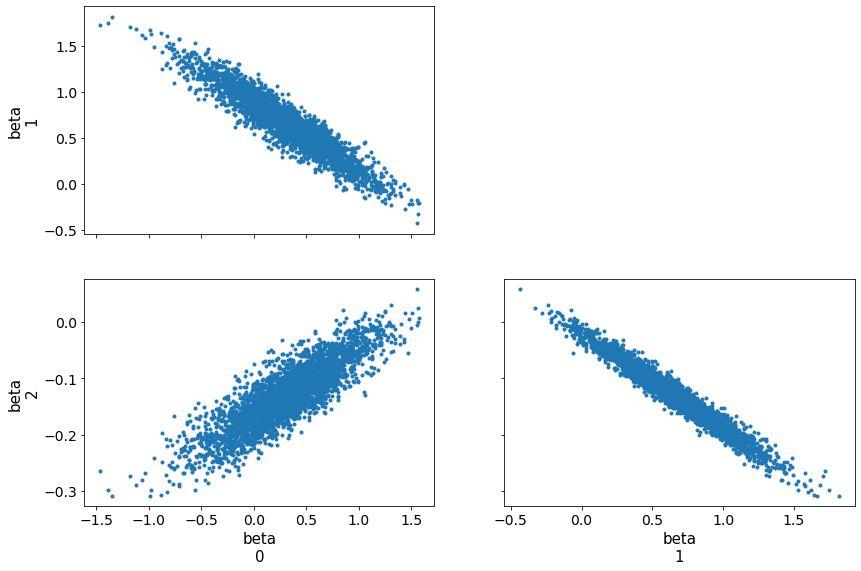

In [24]:
# plots
av.plot_pair(fit_mcmc)

array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>]], dtype=object)

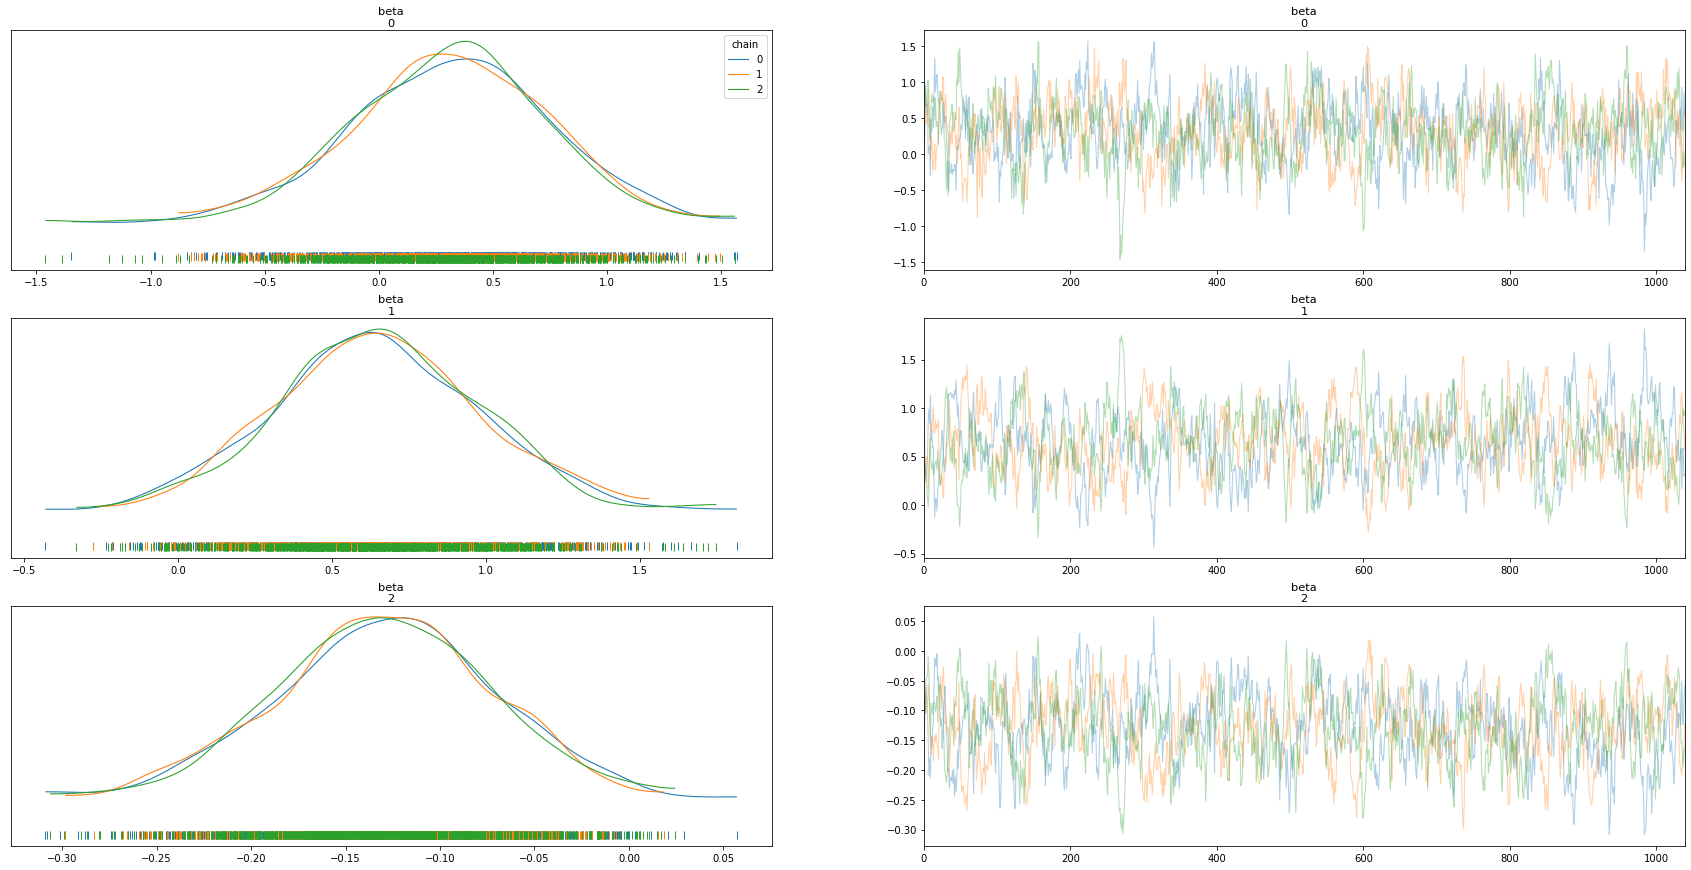

In [25]:
av.plot_trace(fit_mcmc,compact = False,legend = True,figsize = (30,15),rug = True)

## Referencias

<img src="Hoffcoverbook.jpg" width = 250 />

<img src="Gelmancoverbook.png" width = 250 />

<img src="Reichcoverbook.jpg" width = 250 />